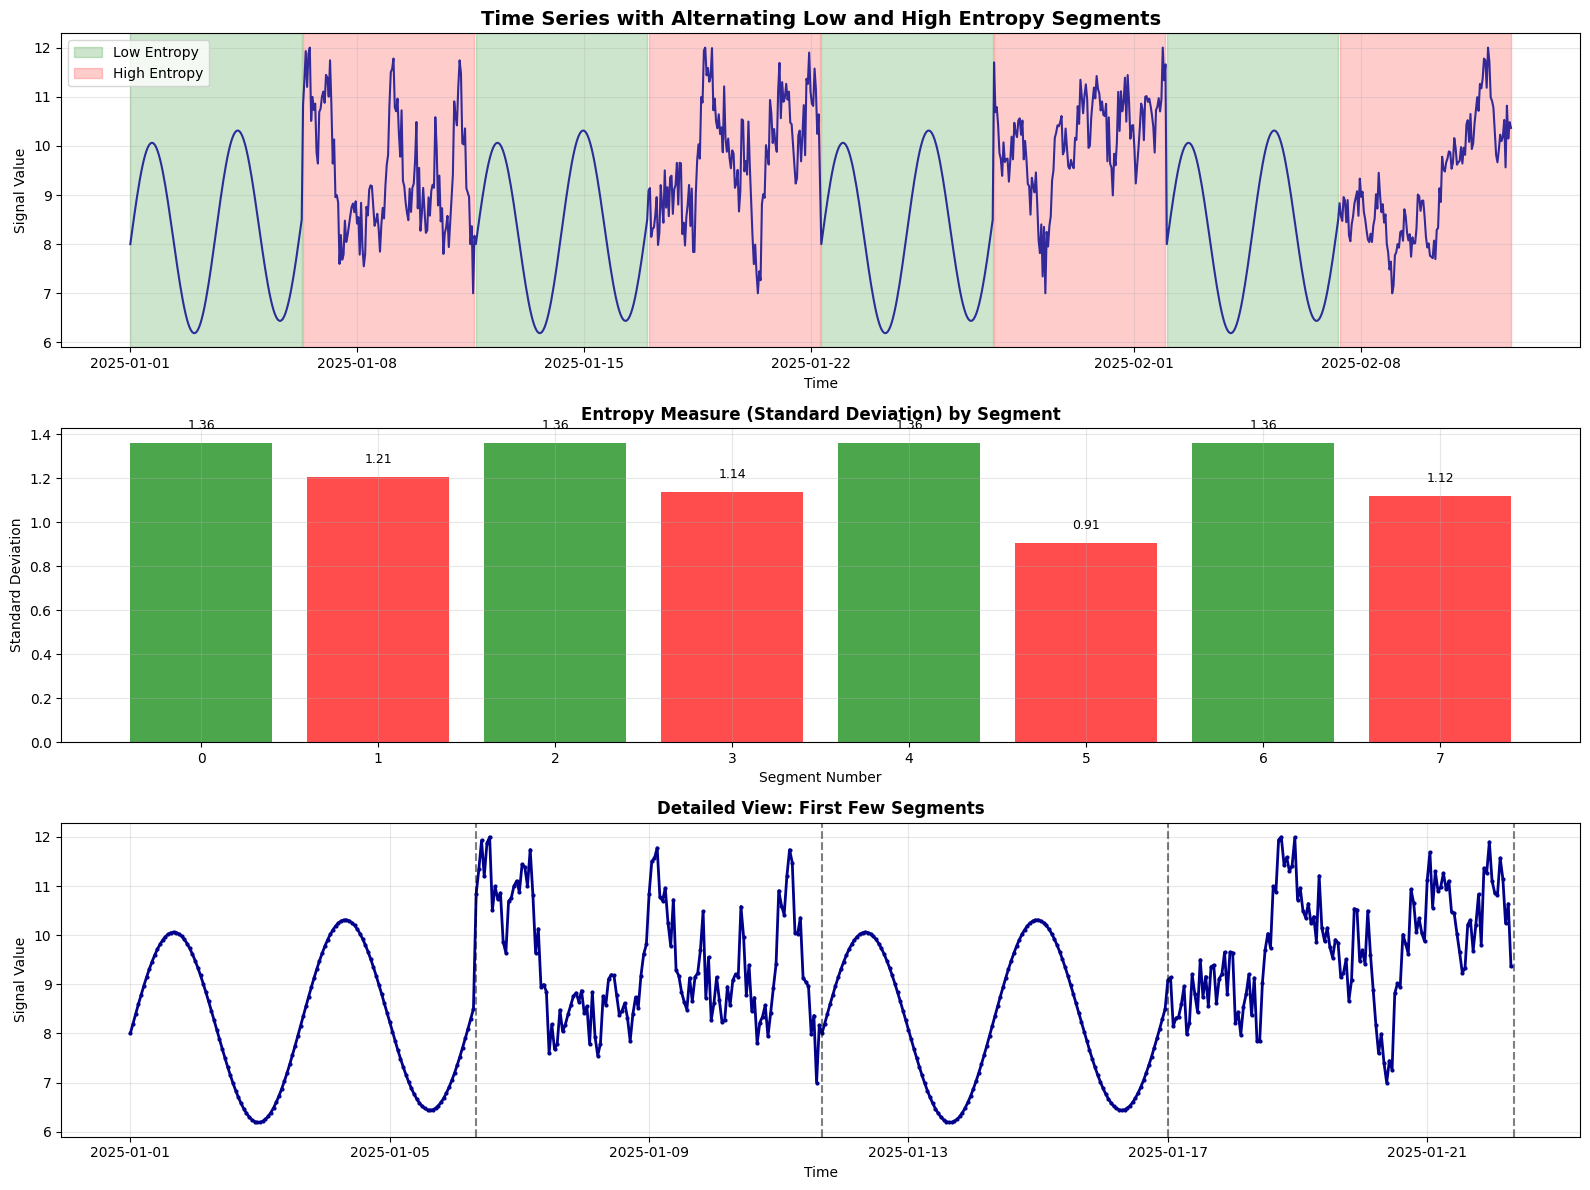


=== SIGNAL GENERATION SUMMARY ===
Generated 1024 samples with 8 complete segments
Segment length: 128 samples
Data saved to: output/entropy_signal.csv
Date range: 2025-01-01 00:00:00 to 2025-02-12 15:00:00

Entropy Analysis:
Average Low Entropy Std Dev: 1.359
Average High Entropy Std Dev: 1.092
Entropy Ratio (High/Low): 0.80


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

def generate_low_high_entropy_signal(num_samples=1024, start_date='2025-01-01', 
                                   output_dir='datasets', filename='entropy_signal.csv',
                                   base_segment_length=128, low_entropy_amplitude=3,
                                   high_entropy_base=7, high_entropy_range=4,
                                   min_high_entropy_fraction=0.25, max_high_entropy_fraction=1.0):
    """
    Generate synthetic time series with alternating low and high entropy segments.
    High entropy segments have random widths between min_fraction and max_fraction of base_segment_length.
    
    Parameters:
    - num_samples: Total number of data points
    - start_date: Starting date for timestamps
    - output_dir: Directory to save output files
    - filename: Name of output CSV file
    - base_segment_length: Base length for segments (low entropy uses this, high entropy varies)
    - low_entropy_amplitude: Amplitude of smooth sine wave (low entropy)
    - high_entropy_base: Base value for high entropy segments
    - high_entropy_range: Range of variation for high entropy segments
    - min_high_entropy_fraction: Minimum fraction of base_segment_length for high entropy (0.25 = 1/4)
    - max_high_entropy_fraction: Maximum fraction of base_segment_length for high entropy (1.0 = 1x)
    """
    
    # Create hourly timestamps
    start_dt = pd.to_datetime(start_date)
    timestamps = [start_dt + timedelta(hours=i) for i in range(num_samples)]
    
    # Initialize signal array and tracking variables
    signal = np.zeros(num_samples)
    current_idx = 0
    segment_info = []  # Track segment information for visualization
    
    # Define multiple frequencies for complex high entropy segments
    high_entropy_frequencies = [0.1, 0.3, 0.8, 1.2, 2.5, 4.0]
    
    # Set random seed for reproducible results
    np.random.seed(42)
    
    # Generate segments until we fill all samples
    segment_count = 0
    
    while current_idx < num_samples:
        remaining_samples = num_samples - current_idx
        
        if segment_count % 2 == 0:
            # Low entropy segment: fixed width
            segment_length = min(base_segment_length, remaining_samples)
            segment_type = 'Low Entropy'
            
            # Generate smooth sine wave with slight trend
            t = np.linspace(0, 4 * np.pi, segment_length)  # 2 complete cycles per segment
            base_wave = low_entropy_amplitude * np.sin(t)
            trend = 0.5 * np.linspace(0, 1, segment_length)  # Slight upward trend
            signal[current_idx:current_idx + segment_length] = base_wave + trend + 8
            
        else:
            # High entropy segment: random width between min and max fraction
            random_fraction = np.random.uniform(min_high_entropy_fraction, max_high_entropy_fraction)
            segment_length = min(int(base_segment_length * random_fraction), remaining_samples)
            segment_type = 'High Entropy'
            
            # Generate complex multi-frequency signal with noise
            t = np.linspace(0, 4 * np.pi * random_fraction, segment_length)
            complex_signal = np.zeros(segment_length)
            
            # Add multiple sine waves with different frequencies and phases
            for freq in high_entropy_frequencies:
                phase = np.random.uniform(0, 2*np.pi)
                amplitude = np.random.uniform(0.5, 1.5)
                complex_signal += amplitude * np.sin(freq * t + phase)
            
            # Add random walk component
            random_walk = np.cumsum(np.random.normal(0, 0.3, segment_length))
            random_walk = random_walk - random_walk[0]  # Start from zero
            
            # Add white noise
            noise = np.random.normal(0, 0.8, segment_length)
            
            # Combine all components
            combined_signal = complex_signal + random_walk + noise
            
            # Normalize and scale to desired range
            if np.max(combined_signal) != np.min(combined_signal):  # Avoid division by zero
                normalized = (combined_signal - np.min(combined_signal)) / (np.max(combined_signal) - np.min(combined_signal))
                signal[current_idx:current_idx + segment_length] = normalized * high_entropy_range + high_entropy_base
            else:
                signal[current_idx:current_idx + segment_length] = high_entropy_base
        
        # Store segment information
        segment_info.append({
            'start_idx': current_idx,
            'end_idx': current_idx + segment_length,
            'length': segment_length,
            'type': segment_type,
            'fraction': segment_length / base_segment_length if segment_type == 'High Entropy' else 1.0
        })
        
        # Move to next segment
        current_idx += segment_length
        segment_count += 1
    
    # Calculate entropy indicators for each segment
    entropy_indicators = []
    segment_types = []
    segment_lengths = []
    
    for seg_info in segment_info:
        start_idx = seg_info['start_idx']
        end_idx = seg_info['end_idx']
        segment_data = signal[start_idx:end_idx]
        
        # Simple entropy measure: standard deviation
        segment_entropy = np.std(segment_data)
        entropy_indicators.append(segment_entropy)
        segment_types.append(seg_info['type'])
        segment_lengths.append(seg_info['length'])
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': timestamps,
        'signal': signal
    })
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Save to CSV
    output_path = os.path.join(output_dir, filename)
    df.to_csv(output_path, index=False)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(4, 1, figsize=(18, 16))
    
    # Main signal plot
    axes[0].plot(df['date'], df['signal'], linewidth=1.5, color='darkblue', alpha=0.8)
    axes[0].set_title('Time Series with Random-Width High Entropy Segments', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Signal Value')
    axes[0].grid(True, alpha=0.3)
    
    # Add colored background to show entropy regions with varying widths
    legend_added = {'Low Entropy': False, 'High Entropy': False}
    for seg_info in segment_info:
        start_time = timestamps[seg_info['start_idx']]
        end_time = timestamps[min(seg_info['end_idx'] - 1, len(timestamps) - 1)]
        
        if seg_info['type'] == 'Low Entropy':
            color = 'green'
            label = 'Low Entropy' if not legend_added['Low Entropy'] else ""
            legend_added['Low Entropy'] = True
        else:
            color = 'red'
            label = 'High Entropy' if not legend_added['High Entropy'] else ""
            legend_added['High Entropy'] = True
        
        axes[0].axvspan(start_time, end_time, alpha=0.2, color=color, label=label)
    
    axes[0].legend()
    
    # Entropy measure plot
    colors = ['green' if seg_type == 'Low Entropy' else 'red' for seg_type in segment_types]
    bars = axes[1].bar(range(len(entropy_indicators)), entropy_indicators, color=colors, alpha=0.7)
    axes[1].set_title('Entropy Measure (Standard Deviation) by Segment', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Segment Number')
    axes[1].set_ylabel('Standard Deviation')
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, entropy) in enumerate(zip(bars, entropy_indicators)):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                    f'{entropy:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Segment length visualization
    colors_length = ['green' if seg_type == 'Low Entropy' else 'red' for seg_type in segment_types]
    bars_length = axes[2].bar(range(len(segment_lengths)), segment_lengths, color=colors_length, alpha=0.7)
    axes[2].set_title('Segment Lengths (Random High Entropy Widths)', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Segment Number')
    axes[2].set_ylabel('Segment Length (samples)')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=base_segment_length, color='black', linestyle='--', alpha=0.5, label='Base Length')
    axes[2].axhline(y=base_segment_length * min_high_entropy_fraction, color='orange', linestyle=':', alpha=0.7, label='Min High Entropy')
    axes[2].legend()
    
    # Add length labels on bars
    for i, (bar, length) in enumerate(zip(bars_length, segment_lengths)):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{length}', ha='center', va='bottom', fontsize=8)
    
    # Detailed view of first few segments
    detail_samples = min(6 * base_segment_length, num_samples)
    axes[3].plot(df['date'][:detail_samples], df['signal'][:detail_samples], 
                linewidth=2, color='darkblue', marker='o', markersize=1.5)
    axes[3].set_title('Detailed View: First Few Segments Showing Variable Widths', fontsize=12, fontweight='bold')
    axes[3].set_xlabel('Time')
    axes[3].set_ylabel('Signal Value')
    axes[3].grid(True, alpha=0.3)
    
    # Add segment boundaries and labels
    for i, seg_info in enumerate(segment_info):
        if seg_info['start_idx'] < detail_samples:
            boundary_time = timestamps[seg_info['start_idx']]
            axes[3].axvline(x=boundary_time, color='black', linestyle='--', alpha=0.5)
            
            # Add segment type and length annotation
            mid_time = timestamps[min(seg_info['start_idx'] + seg_info['length']//2, len(timestamps)-1)]
            axes[3].annotate(f'{seg_info["type"][:4]}\n{seg_info["length"]}', 
                           xy=(mid_time, axes[3].get_ylim()[1]), 
                           xytext=(0, -20), textcoords='offset points',
                           ha='center', va='top', fontsize=8, alpha=0.7)
        
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== SIGNAL GENERATION SUMMARY ===")
    print(f"Generated {num_samples} samples with {len(segment_info)} segments")
    print(f"Base segment length: {base_segment_length} samples")
    print(f"High entropy width range: {min_high_entropy_fraction:.2f} to {max_high_entropy_fraction:.2f} × base length")
    print(f"Data saved to: {output_path}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    
    # Analyze segment statistics
    low_entropy_segments = [seg for seg in segment_info if seg['type'] == 'Low Entropy']
    high_entropy_segments = [seg for seg in segment_info if seg['type'] == 'High Entropy']
    
    print(f"\nSegment Analysis:")
    print(f"Low entropy segments: {len(low_entropy_segments)}")
    print(f"High entropy segments: {len(high_entropy_segments)}")
    
    if high_entropy_segments:
        high_entropy_lengths = [seg['length'] for seg in high_entropy_segments]
        print(f"High entropy lengths - Min: {min(high_entropy_lengths)}, Max: {max(high_entropy_lengths)}, Avg: {np.mean(high_entropy_lengths):.1f}")
        print(f"High entropy fractions - Min: {min(high_entropy_lengths)/base_segment_length:.2f}, Max: {max(high_entropy_lengths)/base_segment_length:.2f}")
    
    print(f"\nEntropy Analysis:")
    low_entropy_std = np.mean([entropy_indicators[i] for i, seg_type in enumerate(segment_types) if seg_type == 'Low Entropy'])
    high_entropy_std = np.mean([entropy_indicators[i] for i, seg_type in enumerate(segment_types) if seg_type == 'High Entropy'])
    
    print(f"Average Low Entropy Std Dev: {low_entropy_std:.3f}")
    print(f"Average High Entropy Std Dev: {high_entropy_std:.3f}")
    print(f"Entropy Ratio (High/Low): {high_entropy_std/low_entropy_std:.2f}")
    
    return df, output_path, segment_info

# Generate and visualize the entropy signal with random-width high entropy patches
df, path, segments = generate_low_high_entropy_signal(
    num_samples=1024,
    start_date='2025-01-01',
    base_segment_length=128,
    low_entropy_amplitude=2,
    high_entropy_base=7,
    high_entropy_range=5,
    min_high_entropy_fraction=0.25,  # 1/4 time period minimum
    max_high_entropy_fraction=1.0    # 1 full time period maximum
)
